In [251]:
import librosa
from sklearn.preprocessing import scale

In [1]:
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(use_memory_fs=False)
import difflib

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [335]:
import biopandas as bpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost


from ast import literal_eval
from biopandas.pdb import PandasPdb
from pypdb import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import spearmanr

In [3]:
notation = '''Alanine (Ala, A)
Arginine (Arg, R)
Asparagine (Asn, N)
Aspartic acid (Asp, D)
Cysteine (Cys, C)
Glutamic acid (Glu, E)
Glutamine (Gln, Q)
Glycine (Gly, G)
Histidine (His, H)
Isoleucine (Ile, I)
Leucine (Leu, L)
Lysine (Lys, K)
Methionine (Met, M)
Phenylalanine (Phe, F)
Proline (Pro, P)
Serine (Ser, S)
Threonine (Thr, T)
Tryptophan (Trp, W)
Tyrosine (Tyr, Y)
Valine (Val, V)'''

protein_notation = notation.split('\n')

protein_dict = {}
for protein in protein_notation:
    letter = protein.split(',')[1].strip()[0] 
    word =  protein.split('(')[0].strip().lower()
    protein_dict[letter] = word

    
protein_dict2 = {}
for protein in protein_notation:
    letter = protein.split(',')[1].strip()[0] 
    word =  protein.split('(')[1].split(',')[0].strip().lower()
    protein_dict2[word] = letter
    

In [4]:
df_train = pd.read_csv("./starting_folder/raw_data/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./starting_folder/raw_data/train_updates_20220929.csv", index_col="seq_id")

In [5]:
all_features_nan = df_train_updates.isnull().all("columns")
drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]
df_train = df_train[df_train.protein_sequence.notna()]
df_train = df_train[df_train.pH.notna()]

In [6]:
# def query_similar_proteins(protein_sequence):
#     q = Query(
#         protein_sequence, 
#         query_type="sequence",
#         return_type='entry'
#     )
#     return q.search()

In [7]:
# def query_similar_proteins2(protein_sequence):
#     qlink = f'https://www.rcsb.org/search?request=%7B%22query%22%3A%7B%22type%22%3A%22group%22%2C%22logical_operator%22%3A%22and%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22sequence%22%2C%22parameters%22%3A%7B%22evalue_cutoff%22%3A0.1%2C%22identity_cutoff%22%3A0%2C%22sequence_type%22%3A%22protein%22%2C%22value%22%3A%22{protein_sequence}%22%7D%7D%5D%7D%2C%22return_type%22%3A%22polymer_entity%22%2C%22request_options%22%3A%7B%22paginate%22%3A%7B%22start%22%3A0%2C%22rows%22%3A25%7D%2C%22results_content_type%22%3A%5B%22experimental%22%5D%2C%22scoring_strategy%22%3A%22combined%22%2C%22sort%22%3A%5B%7B%22sort_by%22%3A%22score%22%2C%22direction%22%3A%22desc%22%7D%5D%7D%2C%22request_info%22%3A%7B%22query_id%22%3A%22945f02da7b942cba20be33557a0b523c%22%7D%7D'
#     return qlink

In [8]:
#similar_proteins_list = df_train.protein_sequence.parallel_apply(query_similar_proteins)
#pd.DataFrame(similar_proteins_list).to_csv('./similar_protein_sequences.csv')

In [9]:
#proteins_lists_df = pd.DataFrame(similar_proteins_list)
proteins_lists_df = pd.read_csv(
    './similar_protein_sequences.csv',
    index_col=0
)
proteins_lists_df.dropna(inplace=True)

In [10]:
proteins_lists_df['protein_names'] = proteins_lists_df.protein_sequence.apply(literal_eval)

In [13]:
extended_proteins_list_df

,protein_sequence,protein_names
seq_id,,
0,['1SR8'],1SR8
1,['1WI9'],1WI9
2,"['6JZB', '6PSI', '4J80', '2CTT', '6IWS', '2DN9...",6JZB
2,"['6JZB', '6PSI', '4J80', '2CTT', '6IWS', '2DN9...",6PSI
2,"['6JZB', '6PSI', '4J80', '2CTT', '6IWS', '2DN9...",4J80
...,...,...
31388,"['2E0W', '4Y23', '4GDX', '4ZBK', '7LBC', '4ZC6...",3GA9
31388,"['2E0W', '4Y23', '4GDX', '4ZBK', '7LBC', '4ZC6...",2I3O
31388,"['2E0W', '4Y23', '4GDX', '4ZBK', '7LBC', '4ZC6...",5HFT


In [16]:
extended_proteins_list_df = proteins_lists_df.explode('protein_names').drop('protein_sequence', axis=1)

In [22]:
protein_name_list = pd.Series(extended_proteins_list_df.protein_names.unique())

In [61]:
downloaded_protein_name_list = os.listdir('./protein_data/')
downloaded_protein_name_series = pd.Series(downloaded_protein_name_list).str.replace('.csv', '')
missing_proteins = protein_name_list[~protein_name_list.isin(downloaded_protein_name_series)]

/tmp/ipykernel_11694/3557773259.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  downloaded_protein_name_series = pd.Series(downloaded_protein_name_list).str.replace('.csv', '')


In [59]:
def get_relevant_info(protein_name):
    url = f'https://files.rcsb.org/view/{protein_name}.pdb'
    text = requests.get(url).text
    bio_pandas_info = PandasPdb().read_pdb_from_list(text.split('\n'))
    df_dict = bio_pandas_info.df
    ATOM = df_dict['ATOM']
    HETATM = df_dict['HETATM']
    if len(HETATM):
        ATOM = pd.concat([ATOM, HETATM], ignore_index=True)
    drop_list = ['blank_1', 'blank_2', 'blank_3', 'blank_4', 'alt_loc', 'insertion', 'segment_id']
    final_info = ATOM.sort_values('atom_number').drop(drop_list, axis=1)
    final_info.to_csv(f'./protein_data/{protein_name}.csv', compression='gzip')

In [95]:
# #protein_name_list.parallel_apply(get_relevant_info)
missing_proteins.parallel_apply(get_relevant_info)

Experimetns

In [211]:
index = 1000
local_information = pd.read_csv(
    f'./protein_data/{proteins_lists_df.protein_names.iloc[index][0]}.csv', compression='gzip', index_col=0
)
scraped = ''.join(local_information[local_information.record_name=='ATOM'].groupby(
    'residue_number').residue_name.first().str.lower().replace(protein_dict2).to_list())

original = df_train.iloc[index].protein_sequence

In [261]:
local_information#.charge.value_counts()

,record_name,atom_number,atom_name,residue_name,chain_id,residue_number,x_coord,y_coord,z_coord,occupancy,b_factor,element_symbol,charge,line_idx
0,ATOM,1,N,GLU,A,528,-0.205,35.496,13.048,1.0,58.96,N,NaN,489
1,ATOM,2,CA,GLU,A,528,0.236,34.347,13.823,1.0,44.09,C,NaN,491
2,ATOM,3,C,GLU,A,528,-0.904,33.395,14.232,1.0,47.23,C,NaN,493
3,ATOM,4,O,GLU,A,528,-1.035,33.075,15.414,1.0,42.69,O,NaN,495
4,ATOM,5,CB,GLU,A,528,0.971,34.834,15.073,1.0,50.86,C,NaN,497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,HETATM,3186,O,HOH,A,1180,-38.825,-1.650,4.060,1.0,67.18,O,NaN,6858
3185,HETATM,3187,O,HOH,A,1181,-19.304,-8.769,6.832,1.0,49.24,O,NaN,6860
3186,HETATM,3188,O,HOH,A,1182,6.525,30.729,23.098,1.0,60.78,O,NaN,6862
3187,HETATM,3189,O,HOH,A,1183,-35.589,-0.781,16.803,1.0,60.16,O,NaN,6864


In [277]:
#plt.plot(local_information.b_factor)



/tmp/ipykernel_11694/618921844.py:5: FutureWarning: Pass y=[58.96 44.09 47.23 ... 60.78 60.16 58.86] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroid = pd.Series(librosa.feature.spectral_centroid(music_array, sr=len(music_array))[0]).describe()
/tmp/ipykernel_11694/618921844.py:6: FutureWarning: Pass y=[58.96 44.09 47.23 ... 60.78 60.16 58.86] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = pd.Series(librosa.feature.spectral_rolloff(music_array, sr=len(music_array))[0]).describe()
/tmp/ipykernel_11694/618921844.py:7: FutureWarning: Pass y=[58.96 44.09 47.23 ... 60.78 60.16 58.86] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(music_array, sr=len(music_array))


{'spectral_rolloff__count': 7.0,
 'spectral_rolloff__mean': 964.3076869419643,
 'spectral_rolloff__std': 76.91499289325137,
 'spectral_rolloff__min': 881.3349609375,
 'spectral_rolloff__25%': 903.134765625,
 'spectral_rolloff__50%': 960.74853515625,
 'spectral_rolloff__75%': 1003.569580078125,
 'spectral_rolloff__max': 1094.66162109375}

In [222]:
y = local_information.b_factor.to_numpy()

In [214]:
dict(local_information.b_factor.describe())

{'count': 3189.0,
 'mean': 40.24909062402007,
 'std': 16.55893956368901,
 'min': 12.2,
 '25%': 26.96,
 '50%': 37.27,
 '75%': 50.84,
 'max': 103.87}

In [216]:
total_list = {}
for window_padding in range(1, 20):
    true_count = 0
    total_count = 0
    for i in range(len(original) - window_padding+1):
        total_count += 1
        conv = original[i:i + window_padding]
        convolutional_padding_flag = conv in scraped
        if convolutional_padding_flag:
            true_count += 1     
    total_list[f'window_{window_padding}'] = true_count/total_count
total_list

{'window_1': 1.0,
 'window_2': 0.6421052631578947,
 'window_3': 0.02127659574468085,
 'window_4': 0.0,
 'window_5': 0.0,
 'window_6': 0.0,
 'window_7': 0.0,
 'window_8': 0.0,
 'window_9': 0.0,
 'window_10': 0.0,
 'window_11': 0.0,
 'window_12': 0.0,
 'window_13': 0.0,
 'window_14': 0.0,
 'window_15': 0.0,
 'window_16': 0.0,
 'window_17': 0.0,
 'window_18': 0.0,
 'window_19': 0.0}

In [317]:
def get_conv_results(scraped, original):
    total_list = {}
    for window_padding in range(1, 10):
        true_count = 0
        total_count = 0
        for i in range(len(original) - window_padding+1):
            total_count += 1
            conv = original[i:i + window_padding]
            convolutional_padding_flag = conv in scraped
            if convolutional_padding_flag:
                true_count += 1     
        total_list[f'window_{window_padding}'] = true_count/total_count
    return total_list

def get_spectral_info(df):
    signal_array = df.b_factor.to_numpy()
    spectral_centroid = pd.Series(librosa.feature.spectral_centroid(
        signal_array, sr=len(signal_array))[0]).describe()
    spectral_rolloff = pd.Series(librosa.feature.spectral_rolloff(
        signal_array, sr=len(signal_array))[0]).describe()
    mfccs = librosa.feature.mfcc(signal_array, sr=len(signal_array))
    results = {}
    for mfccs_number, element in enumerate(mfccs):
        results[f'mfccs_{mfccs_number}__mean'] = np.mean(element)
        results[f'mfccs_{mfccs_number}__std'] = np.std(element)
        results[f'mfccs_{mfccs_number}__max'] = np.max(element)
        results[f'mfccs_{mfccs_number}__min'] = np.min(element)

    scd = dict(spectral_centroid.rename(index={
        ix:f'spectral_centroid__{ix}' for ix in spectral_centroid.index}))
    srd = dict(spectral_rolloff.rename(index={
        ix:f'spectral_rolloff__{ix}' for ix in spectral_centroid.index}))
    new_results = {**results,**scd, **srd} 
    return new_results
    
def obtain_additional_information_first(row):
    local_information = pd.read_csv(
        f'./protein_data/{row.related_protein_list[0]}.csv',
        compression='gzip',
        index_col=0
    )
    scraped = ''.join(
        local_information[
            local_information.record_name=='ATOM'
        ].groupby(
            'residue_number'
        ).residue_name.first().str.lower().replace(protein_dict2).to_list()
    )
    original = row.protein_sequence
    conv_results_dict = get_conv_results(scraped, original)
    try:
        spectral_results_dict = get_spectral_info(local_information)
    except:
        spectral_results_dict = {}
    results = {**conv_results_dict,**spectral_results_dict} 
    return pd.Series(results)

In [305]:
test_data = df_train.copy()
test_data['related_protein_list']= proteins_lists_df['protein_names']
test_data = test_data[test_data.related_protein_list.notna()]
test_data['len_related_protein_list'] = test_data.related_protein_list.apply(lambda x: len(x))

0.3809295833333333

In [323]:
import warnings
warnings.filterwarnings('ignore')
additional_test_data = test_data.parallel_apply(lambda x: obtain_additional_information_first(x), axis=1)

In [360]:
additional_test_data.to_csv('./additional_test_data')

In [352]:
def generate_graph(protein_sequence):
    from_to_dict = {
        'from':list(protein_sequence[:-1]),
        'to':list(protein_sequence[1:])
    }
    protein_sequence_directions = pd.DataFrame(from_to_dict)
    list_of_paths = protein_sequence_directions.groupby('from').to.agg(list).values.tolist()
    G=nx.Graph()
    for path in list_of_paths:
        nx.add_path(G, path)
    return G
    
def flatten_result_dict(result_dictionary):
    index = []
    values = []
    for key in result_dictionary.keys():
        for letter in result_dictionary[key].keys():
            index.append(f'{key}_{letter}')
            values.append(result_dictionary[key][letter])
    df = pd.DataFrame(values, index=index).T
    return df 

def get_graph_results(graph):
    if True:
        result_dictionary = {
            'degree_dict':dict(graph.degree()),
            'pagerank_dict': nx.pagerank(graph),
            'centrality_eigenvector': nx.eigenvector_centrality(graph),
            'centrality_degree': nx.degree_centrality(graph),
            #'centrality_closeness': nx.closeness_centrality(graph),
        }
        result_dictionary_df = flatten_result_dict(result_dictionary=result_dictionary)
        return result_dictionary_df
        

    
#test_data['protein_graph'] = test_data['protein_sequence'].apply(generate_graph)
more_info = test_data['protein_graph'].apply(get_graph_results)  

In [353]:
more_info

seq_id
0           degree_dict_A  degree_dict_K  degree_dict_L...
1           degree_dict_A  degree_dict_D  degree_dict_G...
2           degree_dict_A  degree_dict_F  degree_dict_T...
3           degree_dict_A  degree_dict_S  degree_dict_I...
4           degree_dict_A  degree_dict_T  degree_dict_S...
                               ...                        
31384       degree_dict_D  degree_dict_S  degree_dict_P...
31385       degree_dict_L  degree_dict_A  degree_dict_G...
31386       degree_dict_M  degree_dict_I  degree_dict_V...
31387       degree_dict_E  degree_dict_Q  degree_dict_I...
31388       degree_dict_I  degree_dict_A  degree_dict_D...
Name: protein_graph, Length: 25255, dtype: object

In [ ]:
# df_lists = []
# for row in more_info:
#     df_lists.append(row)
# graph_df = pd.concat(df_lists, ignore_index=True)

# new_df_train = pd.concat([test_data, graph_df], axis=1, ignore_index=True)

In [ ]:
new_train = pd.concat([test_data,graph_df.set_index(test_data.index)], axis=1)

In [327]:
total_data = pd.concat([additional_test_data, test_data], axis=1)
total_data

,mfccs_0__max,mfccs_0__mean,mfccs_0__min,mfccs_0__std,mfccs_10__max,mfccs_10__mean,mfccs_10__min,mfccs_10__std,mfccs_11__max,mfccs_11__mean,...,window_6,window_7,window_8,window_9,protein_sequence,pH,data_source,tm,related_protein_list,len_related_protein_list
seq_id,,,,,,,,,,,,,,,,,,,,,
0,471.262669,441.845836,417.102681,1.732335e+01,6.506946,3.599406,-1.951854,3.187870,13.108437,5.859227,...,0.000000,0.000000,0.000000,0.000000,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,[1SR8],1
1,-1131.370850,-1131.370850,-1131.370850,2.273737e-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.192171,0.189286,0.186380,0.183453,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,[1WI9],1
2,529.539777,518.385125,500.270650,1.093407e+01,6.911258,5.329406,3.241033,1.491540,8.253659,6.783979,...,0.000000,0.000000,0.000000,0.000000,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,"[6JZB, 6PSI, 4J80, 2CTT, 6IWS, 2DN9, 3LZ8, 6Z5...",68
3,532.981684,517.562775,474.217041,1.715447e+01,6.927935,4.995099,3.180892,1.211481,7.049071,3.291327,...,0.365385,0.328185,0.306202,0.287938,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,"[1P32, 6SZW, 3RPX, 7TE3]",4
4,535.257968,502.041212,489.514504,1.150742e+01,12.315272,6.780239,1.567739,2.708016,6.267616,3.012028,...,0.199862,0.198616,0.197368,0.196119,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,"[7NE1, 7NE0, 7NDG, 4UI2, 4BQC, 4BQ7, 4BQ6, 4BQ...",296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31384,482.396365,462.460227,431.058812,1.696645e+01,5.439408,2.327655,0.178557,1.718449,7.535774,4.053784,...,0.269917,0.259524,0.249106,0.238663,YYLYGWNRGLEPSADASESDCGDPPPVAPSRLLPIKPVQAVAPSRT...,7.0,doi.org/10.1038/s41592-020-0801-4,49.0,"[1NST, 3BD9, 7SCD, 7SCE, 1T8T, 6XKG, 6XL8, 1T8...",12
31385,459.198492,412.466456,368.098075,1.873916e+01,13.928715,5.168147,0.644443,2.566051,15.481714,7.143731,...,0.764706,0.745856,0.728782,0.711645,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8,"[4D0T, 5AJP, 5AJN, 5AJO, 4D11, 5NDF, 4D0Z, 5FV...",30
31386,471.478459,446.554839,416.468398,1.748785e+01,9.605100,6.326008,2.834993,2.248465,7.807302,4.718323,...,0.008621,0.002160,0.000000,0.000000,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2,"[5CCF, 5CK7, 1UA4, 5O0J, 5O0I, 1L2L, 1GC5, 4B8...",16


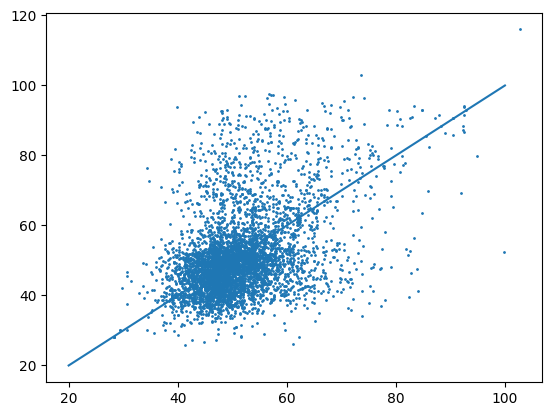

In [330]:
X = total_data.drop(columns = ['tm','protein_sequence', 'data_source', 'related_protein_list', 'pH'])
y = total_data['tm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
model1 = xgboost.XGBRegressor(n_estimators=2500, max_depth=3)
model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)

plt.scatter(predictions1, y_test, s=1)
plt.plot([20,100], [20,100],)

In [331]:
print('Mean Absolute Error =', mean_absolute_error(y_test, predictions1))
print('Mean Absolute Percentage Error = ', mean_absolute_percentage_error(y_test, predictions1))

rho, p = spearmanr(y_test, predictions1)
print('Spearman Correlation Coefficient =', rho.round(3))

Mean Absolute Error = 7.9874338660186375
Mean Absolute Percentage Error =  0.15332930676744244
Spearman Correlation Coefficient = 0.365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


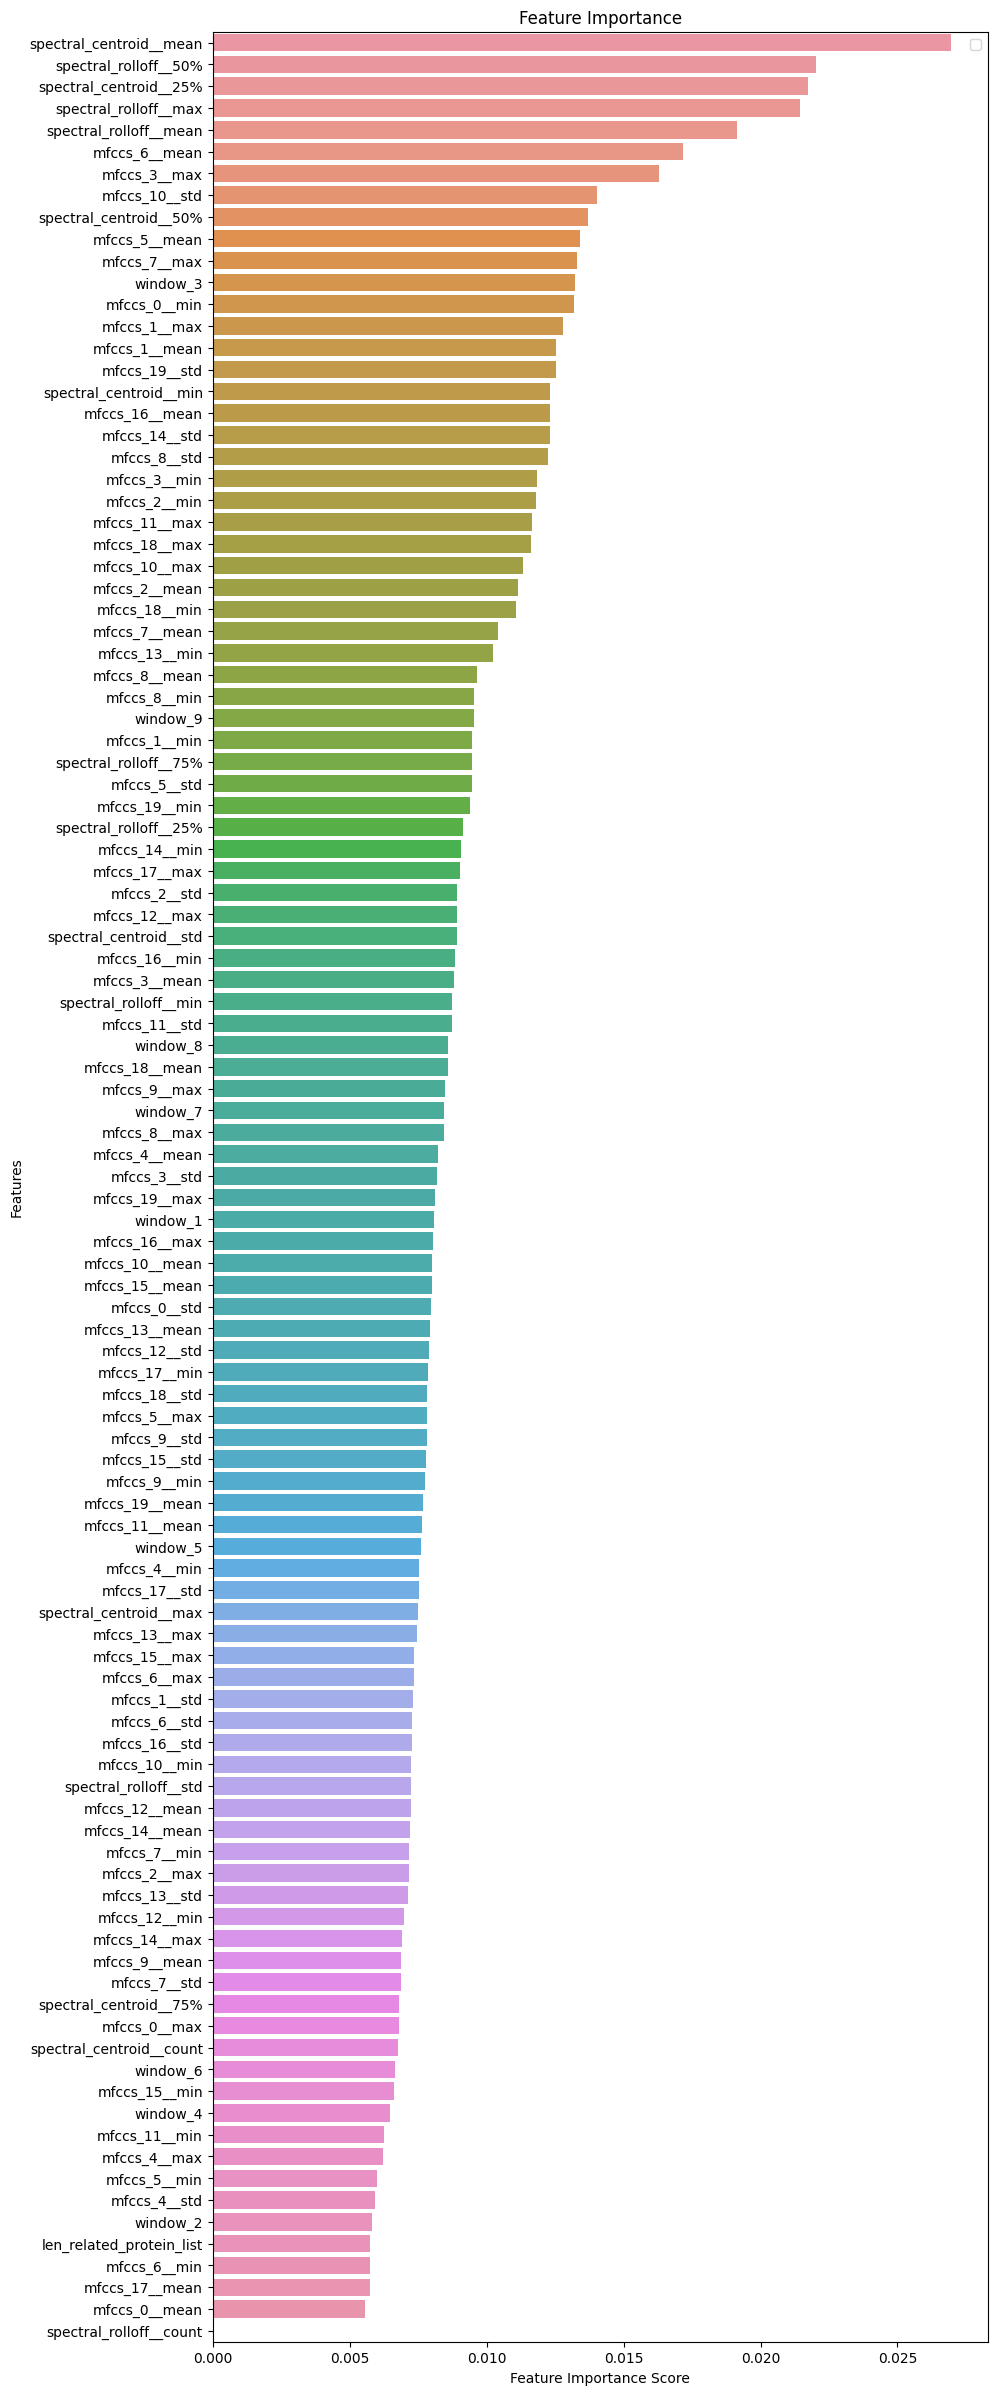

In [332]:
feature_imp = pd.Series(model1.feature_importances_,index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,30))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()

In [276]:
rs = pd.Series(list(retrieved_sequence))
us = pd.Series(list(usual_sequence))
us2 = pd.DataFrame(us)
neighbour_num=11
for idx in range(len(rs)):
    indexes_us = us[us==rs.iloc[idx]].index
    temp_rs = rs.loc[idx+1: idx+neighbour_num]
    string_rs = ''.join(list(temp_rs))
    string_list = []
    for index in indexes_us:
        temp_us = us.loc[index+1: index+neighbour_num]
        string = ''.join(list(temp_us))
        string_list.append(string)
    result = list(map(lambda x: difflib.SequenceMatcher(a=x,b=string_rs).ratio(), string_list))
    us2.loc[indexes_us, f'col_{idx}'] = result
us2[f'total_{neighbour_num}'] = us2[[col for col in us2.drop(0, axis=1).columns if 'col' in col]].mean(axis=1)

/tmp/ipykernel_11501/2305252060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  us2.loc[indexes_us, f'col_{idx}'] = result
/tmp/ipykernel_11501/2305252060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  us2.loc[indexes_us, f'col_{idx}'] = result
/tmp/ipykernel_11501/2305252060.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [284]:
us2[[col for col in us2.drop(0, axis=1).columns if 'tot' in col]].sum(axis=1).sort_values()

304    0.000000
302    0.074556
138    0.141414
303    0.142857
175    0.159091
         ...   
193    0.332405
21     0.333333
55     0.333333
171    0.333333
297    0.361111
Length: 305, dtype: float64

Text(0, 0.5, '$y(t)$')

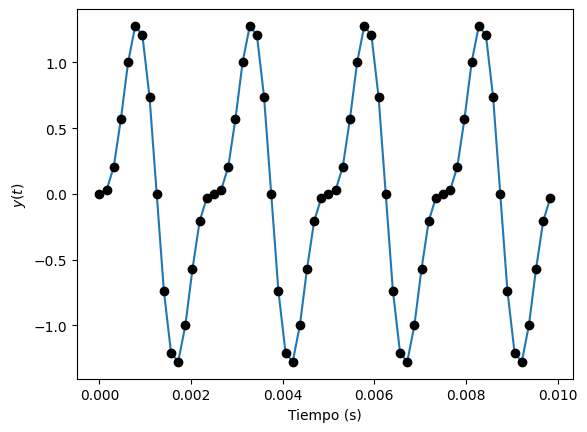

In [221]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
 
n = 2 ** 6 # Número de intervalos
f = 400.0 # Hz
dt = 1 / (f * 16) # Espaciado, 16 puntos por período
t = np.linspace(0, (n - 1) * dt, n) # Intervalo de tiempo en segundos
y = np.sin(2 * pi * f * t) - 0.5 * np.sin(2 * pi * 2 * f * t) # Señal
plt.plot(t, y)
plt.plot(t, y, 'ko')
plt.xlabel('Tiempo (s)')
plt.ylabel('$y(t)$')

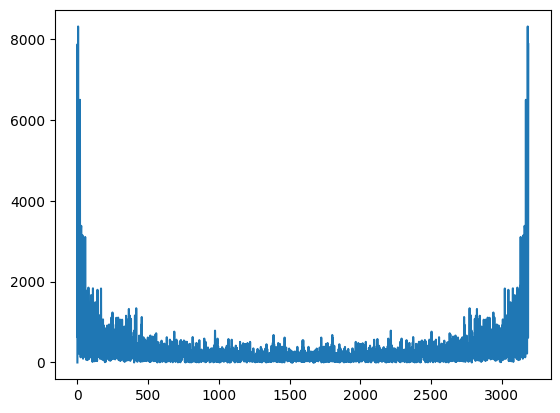

In [225]:
plt.plot(abs(fft(y).imag))

In [359]:
protein_networ_df_init = extended_proteins_list_df.reset_index()

In [ ]:
protein_networ_df_init

In [ ]:
def generate_graph(protein_sequence):
    from_to_dict = {
        'from':list(protein_sequence[:-1]),
        'to':list(protein_sequence[1:])
    }
    protein_sequence_directions = pd.DataFrame(from_to_dict)
    list_of_paths = protein_sequence_directions.groupby('from').to.agg(list).values.tolist()
    G=nx.Graph()
    for path in list_of_paths:
        nx.add_path(G, path)
    return G